## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Assuming X is your feature matrix (neural activity) and y is your target variable (pupil area)
X = dat['sresp'].T
y = dat['pupilArea'].flatten()

# 1. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. Create and train the LassoCV model
alphas = np.logspace(-6, 6, 100)  # Range of alphas to try
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

# 4. Print the best alpha
print(f"Best alpha: {lasso_cv.alpha_:.4f}")

Best alpha: 2.0092


Mean Squared Error: 14719.50
R-squared Score: 0.8913


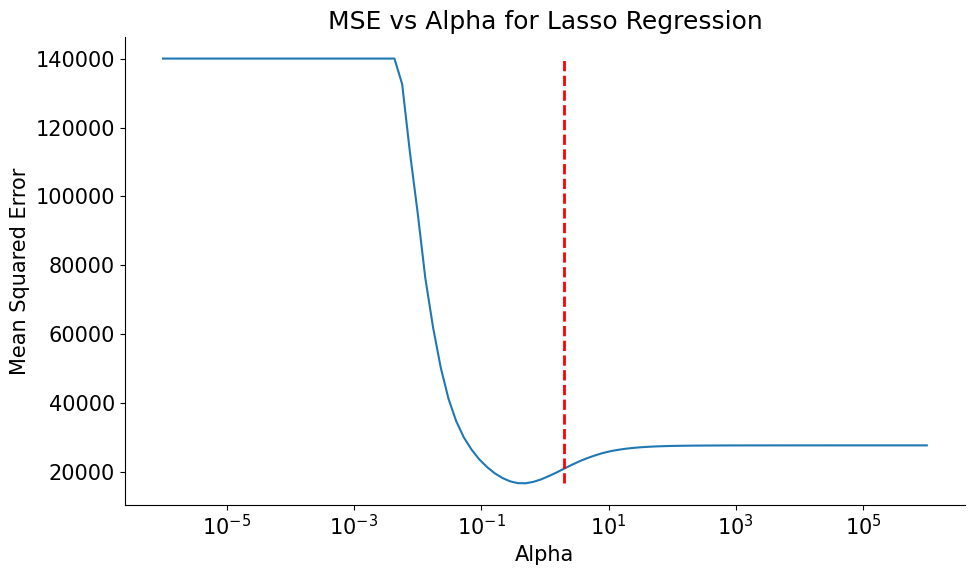

In [ ]:
# 5. Make predictions on the test set
y_pred = lasso_cv.predict(X_test_scaled)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")

# 7. Plot MSE for different alphas
mse_path = np.mean(lasso_cv.mse_path_, axis=1)
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mse_path)
plt.vlines(lasso_cv.alpha_, mse_path.min(), mse_path.max(), color='r', linestyle='--', lw=2)
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso Regression')
plt.tight_layout()
plt.show()

Number of features used by optimized Lasso model: 1666


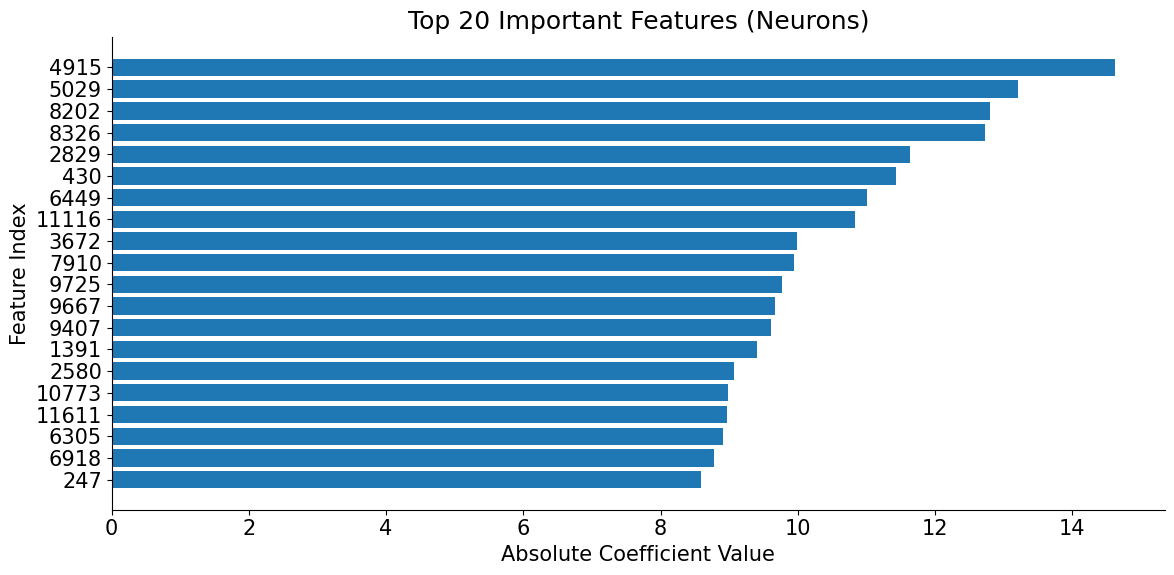

In [ ]:
# 8. Analyze feature importance
feature_importance = np.abs(lasso_cv.coef_)
n_features_used = np.sum(feature_importance != 0)
print(f"Number of features used by optimized Lasso model: {n_features_used}")

# 9. Plot top features
top_features = np.argsort(feature_importance)[-20:]  # Top 20 important features
plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[top_features])
plt.yticks(range(20), top_features)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature Index')
plt.title('Top 20 Important Features (Neurons)')
plt.tight_layout()
plt.show()

In [ ]:
selected_indices = np.nonzero(feature_importance)[0]
print(selected_indices.shape)
print(selected_indices)

(1666,)
[    0     3     6 ... 11961 11962 11981]


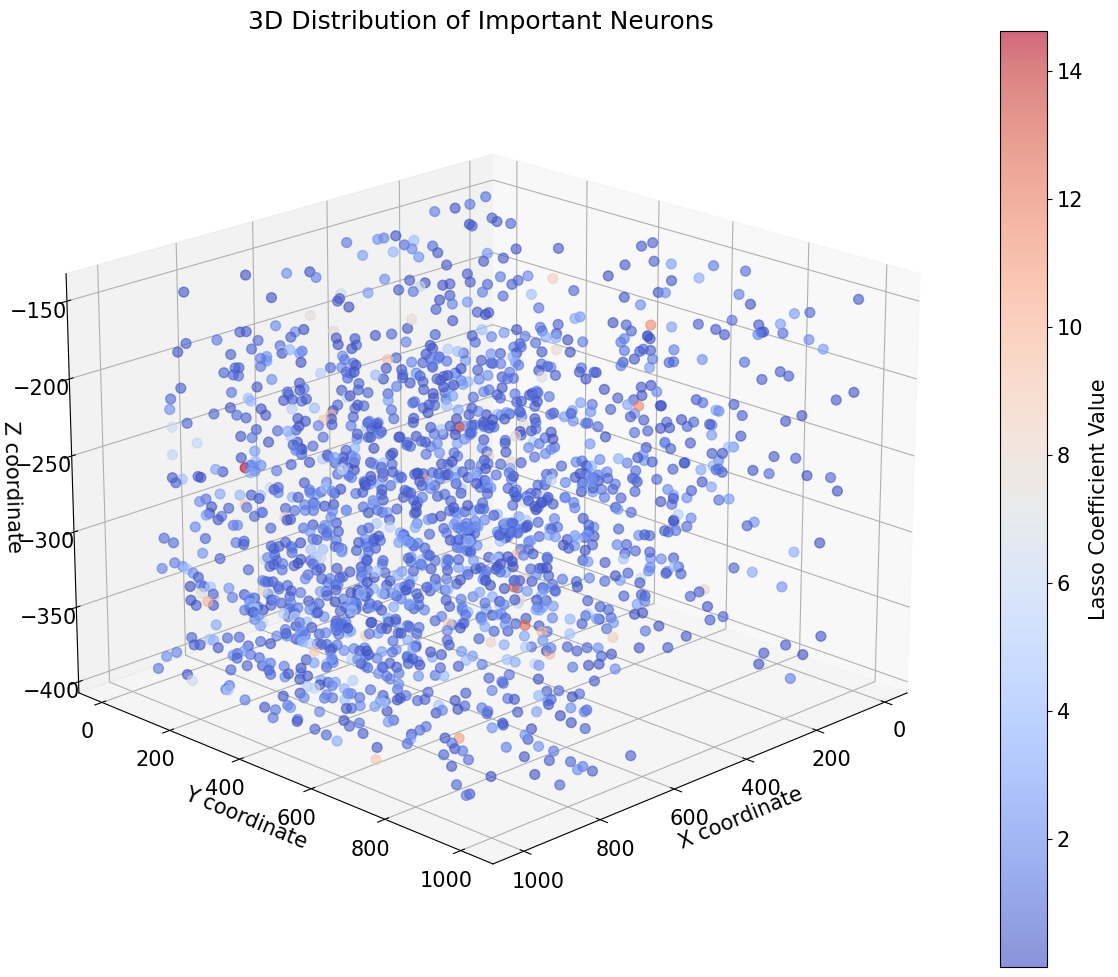

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Extract the coordinates of important neurons
important_neuron_locations = dat['xyz'][:, selected_indices]

# 2. Create the 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3. Plot the points
scatter = ax.scatter(important_neuron_locations[0],
                     important_neuron_locations[1],
                     important_neuron_locations[2],
                     c=feature_importance[selected_indices],  # Color by coefficient value
                     cmap='coolwarm',  # Blue for negative, red for positive coefficients
                     s=50,  # Marker size
                     alpha=0.6)  # Transparency

# 4. Set labels and title
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('Z coordinate')
ax.set_title('3D Distribution of Important Neurons')

# 5. Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Lasso Coefficient Value')

# 6. Improve the view
ax.view_init(elev=20, azim=45)  # Adjust these values for better visualization

# 7. Show the plot
plt.tight_layout()
plt.show()

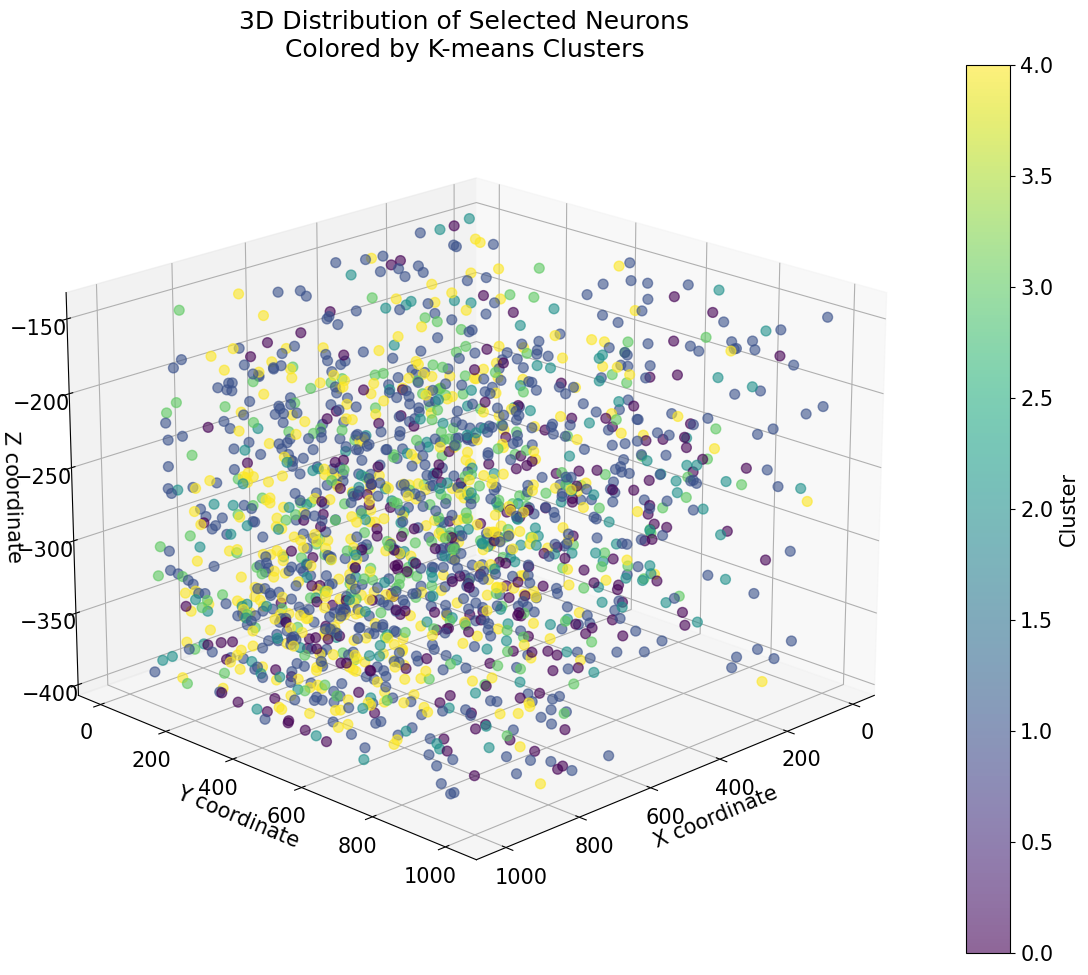

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_neurons = X[:, selected_indices]
neuron_locations = dat['xyz']

# 1. Prepare the data
selected_locations = neuron_locations[:, selected_indices]

# 2. Standardize the neural activity data
scaler = StandardScaler()
selected_neurons_scaled = scaler.fit_transform(selected_neurons)

# 3. Perform K-means clustering
n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(selected_neurons_scaled.T)

# 4. Create the 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 5. Plot the points, coloring them by cluster
scatter = ax.scatter(selected_locations[0],
                     selected_locations[1],
                     selected_locations[2],
                     c=cluster_labels,
                     cmap='viridis',
                     s=50,  # Marker size
                     alpha=0.6)  # Transparency

# 6. Set labels and title
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('Z coordinate')
ax.set_title('3D Distribution of Selected Neurons\nColored by K-means Clusters')

# 7. Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# 8. Improve the view
ax.view_init(elev=20, azim=45)  # Adjust these values for better visualization

# 9. Show the plot
plt.tight_layout()
plt.show()